# Summary:
我的主要目标是建立一个模型来预测销售额，通过探索数据的特点和选择合适的特征，最终实现了对销售的合理预测。
- 数据探索与预处理: 我首先对数据进行了全面的探索，包括检查缺失值、处理异常值以及对数据进行归一化.同时，通过分析特征间的相关性发现，竞争相关特征（如 CompetitionDistance）与销售额的相关性较低，因此未纳入最终的建模过程。
- 特征选择与建模: 在构建模型前，我选取了对销售影响较大的特征（如促销活动、节假日等）作为输入变量，并使用 XGBoost 模型进行训练。在训练模型时，我结合了验证集对模型性能进行评估，并通过设置早停（early stopping）来防止过拟合。
- 遇到的问题与解决方案: 在建模过程中，我发现模型在处理高维度特征时容易导致过拟合，同时部分特征重要性不高可能会引入噪声。为了解决这些问题，我通过调整模型参数（max_depth）以及剔除低相关性特征，成功提高了模型的泛化能力。
- 结果与评估: 最终模型在测试集上的表现令人满意，RMSE 表现出良好的预测效果，表明模型能够较为准确地捕捉销售额的变化趋势。然而，我也注意到模型的预测在极端值场景下可能存在一定误差，未来可以通过进一步优化特征工程或结合其他模型提升效果。

EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split


In [43]:
train_df = pd.read_csv('train.csv')
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')
train_df.shape, store_df.shape, test_df.shape

C:\Users\liuzu\AppData\Local\Temp\ipykernel_19176\3257241228.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


((1017209, 9), (1115, 10), (41088, 8))

In [44]:

# 将日期列转换为日期格式
train_df['Date'] = pd.to_datetime(train_df['Date'])

# 按商店ID合并
data = pd.merge(train_df, store_df, on='Store', how='left')
print(data.shape)

# 只保留开店的数据
data = data[data['Open'] == 1]

# 检查数据基本信息
print("数据基本信息：")
print(data.info())

# 检查数据是否有缺失值
print("\n缺失值统计：")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# 基本统计量
print("\n数值列的统计量：")
print(data.describe())

# 销售额与客流量的相关性
correlation = data['Sales'].corr(data['Customers'])
print(f"\n销售额与客流量的相关性系数：{correlation:.3f}")


(1017209, 18)
数据基本信息：
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        84


销售额平均值为 6,955，但最大值达到了 41,551，表明存在极端值
同样，平均客流量为 762，最大值达到了 7,388，同样存在较大的极端值。
CompetitionDistance 这里平均值约为 5,458 米，最大值达到了 75,860 米，分布较为偏态。

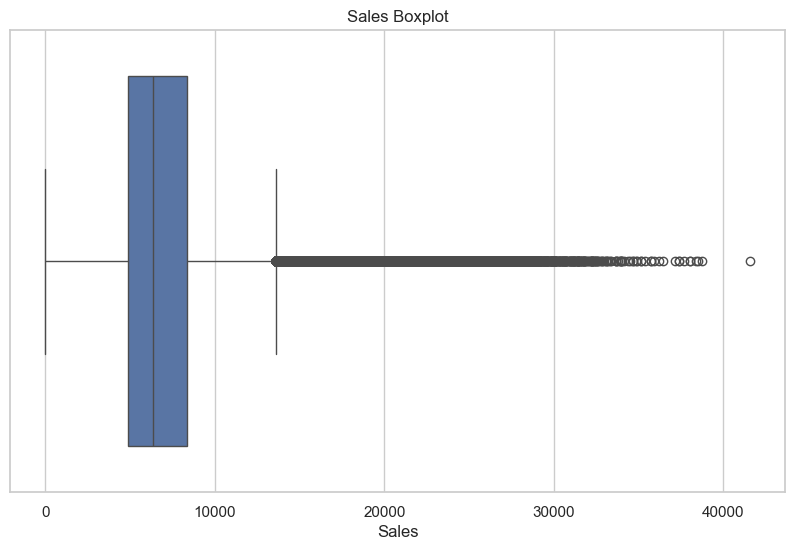

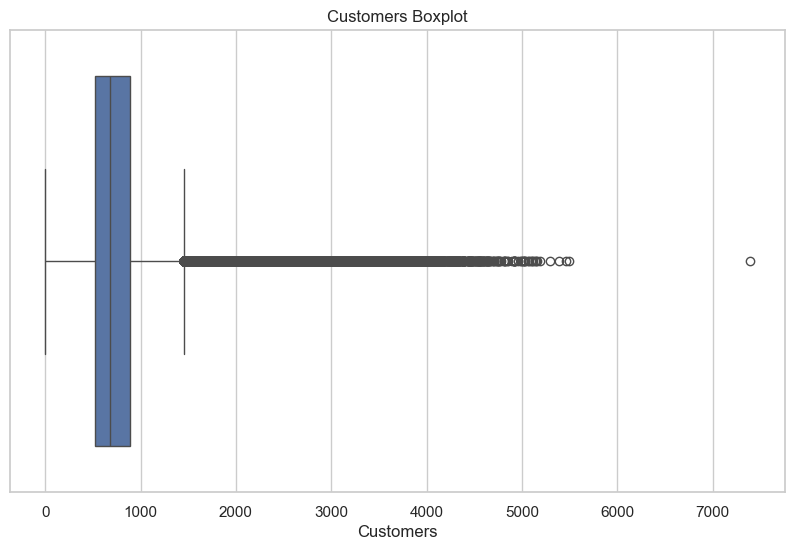

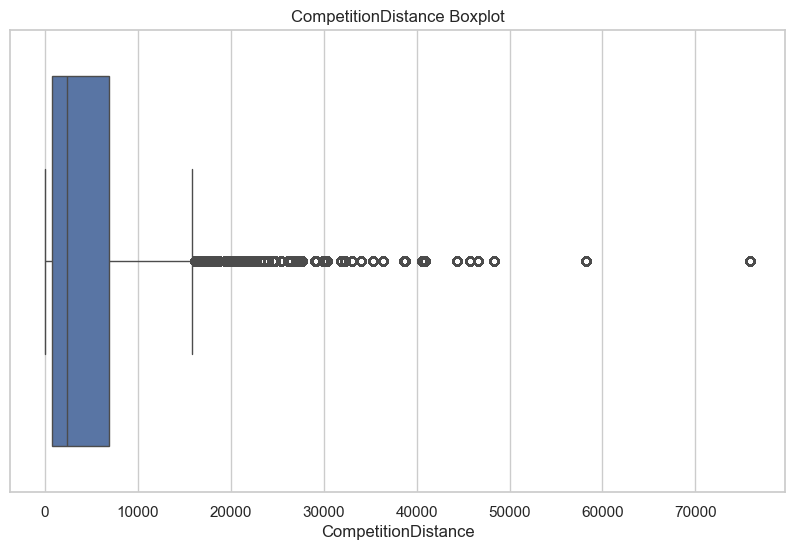

In [45]:
# 绘制箱线图
features = ['Sales', 'Customers', 'CompetitionDistance']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[feature])
    plt.title(f'{feature} Boxplot')
    plt.show()


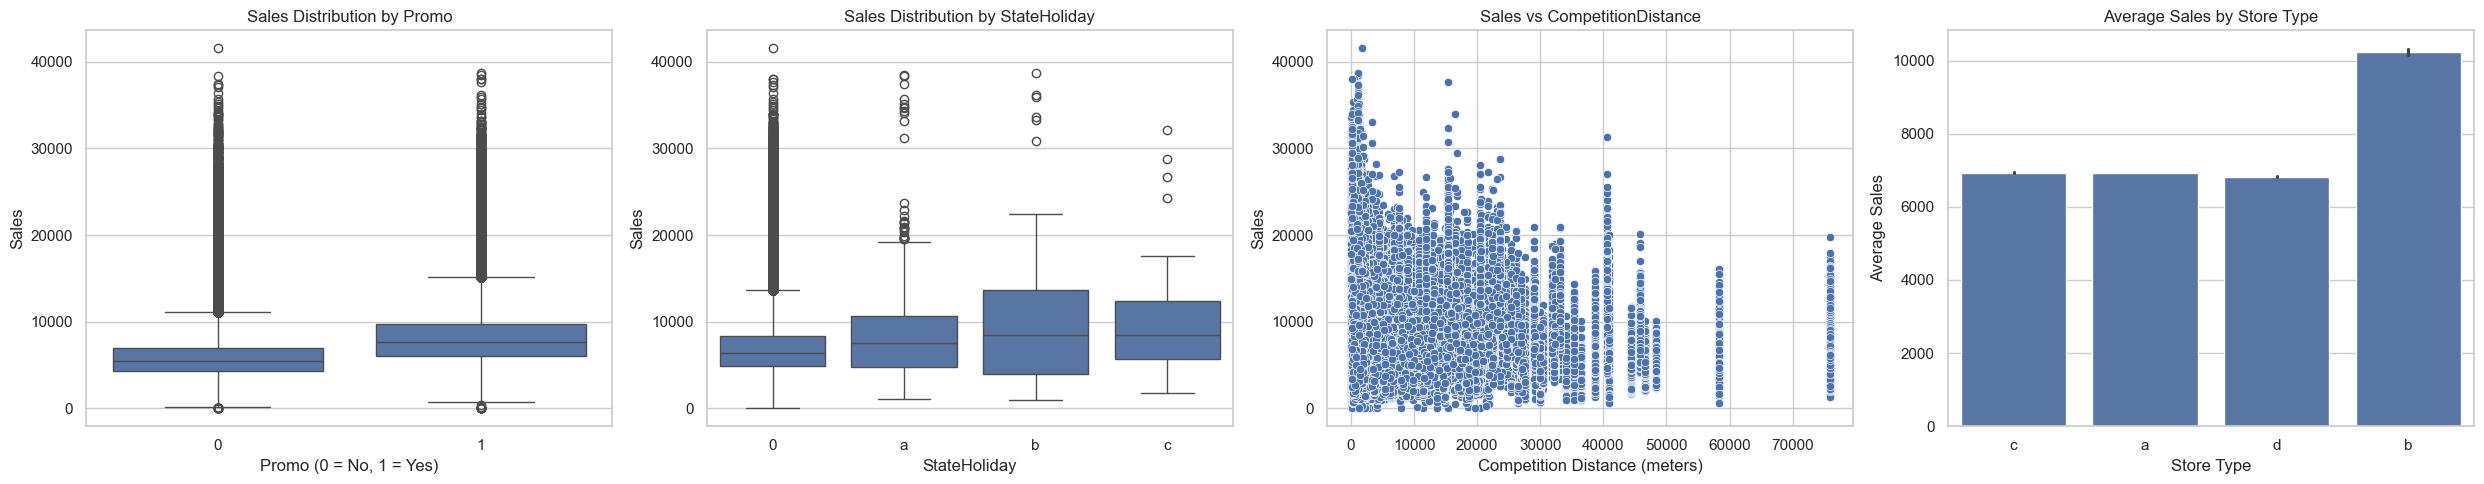

In [46]:
# 设置可视化样式
sns.set(style="whitegrid")

# 创建一个横向排列的子图布局，1行4列
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

# 1. 促销与销售额的关系
sns.boxplot(x="Promo", y="Sales", data=data, ax=axes[0])
axes[0].set_title('Sales Distribution by Promo')
axes[0].set_xlabel('Promo (0 = No, 1 = Yes)')
axes[0].set_ylabel('Sales')

# 2. 节假日与销售额的关系
sns.boxplot(x="StateHoliday", y="Sales", data=data, ax=axes[1])
axes[1].set_title('Sales Distribution by StateHoliday')
axes[1].set_xlabel('StateHoliday')
axes[1].set_ylabel('Sales')

# 3. 竞争距离与销售额的关系
sns.scatterplot(x="CompetitionDistance", y="Sales", data=data, ax=axes[2])
axes[2].set_title('Sales vs CompetitionDistance')
axes[2].set_xlabel('Competition Distance (meters)')
axes[2].set_ylabel('Sales')

# 4. 商店类型与销售额的关系
sns.barplot(x="StoreType", y="Sales", data=data, estimator='mean', ax=axes[3])
axes[3].set_title('Average Sales by Store Type')
axes[3].set_xlabel('Store Type')
axes[3].set_ylabel('Average Sales')

# 调整布局
plt.tight_layout()
plt.show()


- 促销对销售额有正向提升作用。
- 节假日对销售额的影响较大。
- 整体上，竞争距离越大，销售额没有明显的减少趋势，说明距离不是唯一决定销售额的因素。
- 类型为 b 的商店平均销售额明显更高。



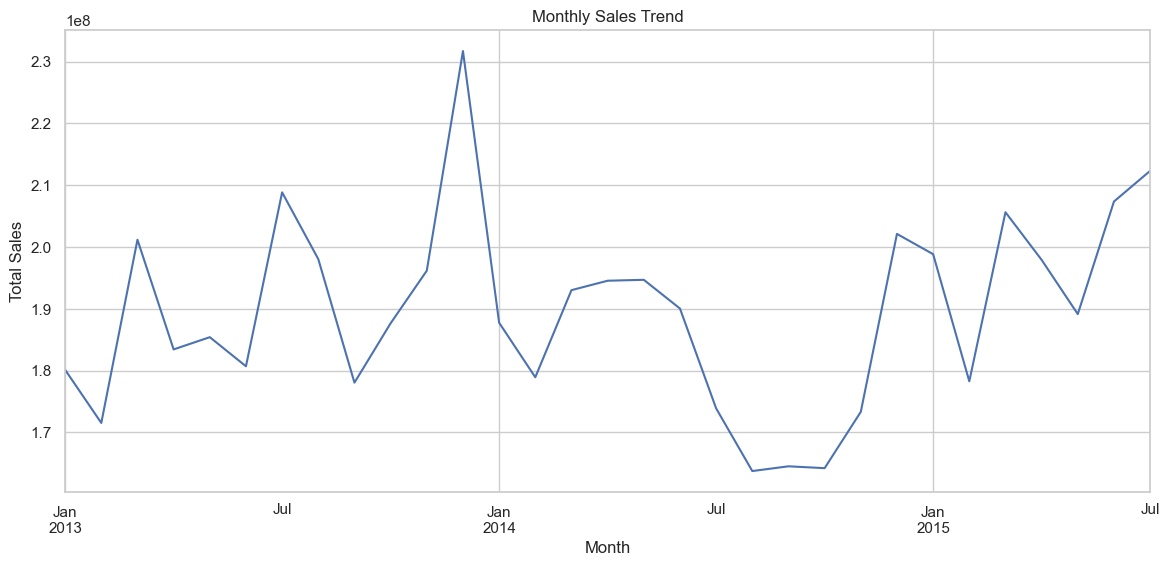

In [47]:
# 按月聚合并绘制
monthly_sales = train_df.groupby(train_df['Date'].dt.to_period('M'))['Sales'].sum()
monthly_sales.plot(figsize=(14, 6), title='Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()



- 销售额在 7 月和 8 月有显著下降

In [48]:
# 对比2013年8月和2014年8月
aug_comparison = data[
    ((data['Date'].dt.year == 2013) & (data['Date'].dt.month == 8)) |
    ((data['Date'].dt.year == 2014) & (data['Date'].dt.month == 8))
].groupby(data['Date'].dt.year).agg({
    'Sales': ['sum', 'mean'],
    'Customers': 'mean',
    'Promo': 'mean',
    'SchoolHoliday': 'mean',
    'Open': 'count',
    'Store': 'nunique'
})

print("2013年和2014年8月数据对比：")
print(aug_comparison)

# 分析2014年8月的具体情况

aug_2014_data = data[
    (data['Date'].dt.year == 2014) & 
    (data['Date'].dt.month == 8)
]

aug_2014_analysis = {
    '总销售额': aug_2014_data['Sales'].sum(),
    '平均每日销售额': aug_2014_data['Sales'].mean(),
    '开店天数': aug_2014_data['Open'].sum(),
    '促销天数占比': aug_2014_data['Promo'].mean(),
    '平均客流量': aug_2014_data['Customers'].mean(),
    '学校假期占比': aug_2014_data['SchoolHoliday'].mean()
}

print("\n2014年8月具体情况：")
for key, value in aug_2014_analysis.items():
    print(f"{key}: {value:.2f}")

2013年和2014年8月数据对比：
          Sales                Customers     Promo SchoolHoliday   Open  \
            sum         mean        mean      mean          mean  count   
Date                                                                      
2013  198042727  6595.927627  743.188410  0.439867      0.575121  30025   
2014  163748475  6714.305191  759.244341  0.420699      0.686608  24388   

       Store  
     nunique  
Date          
2013    1115  
2014     934  

2014年8月具体情况：
总销售额: 163748475.00
平均每日销售额: 6714.31
开店天数: 24388.00
促销天数占比: 0.42
平均客流量: 759.24
学校假期占比: 0.69


看来，2014年8月的销售额下降很可能是由店铺数量减少引起的

促销活动对销售的影响：
         Sales  Customers
Promo                    
0      5929.41     696.86
1      8228.28     844.43


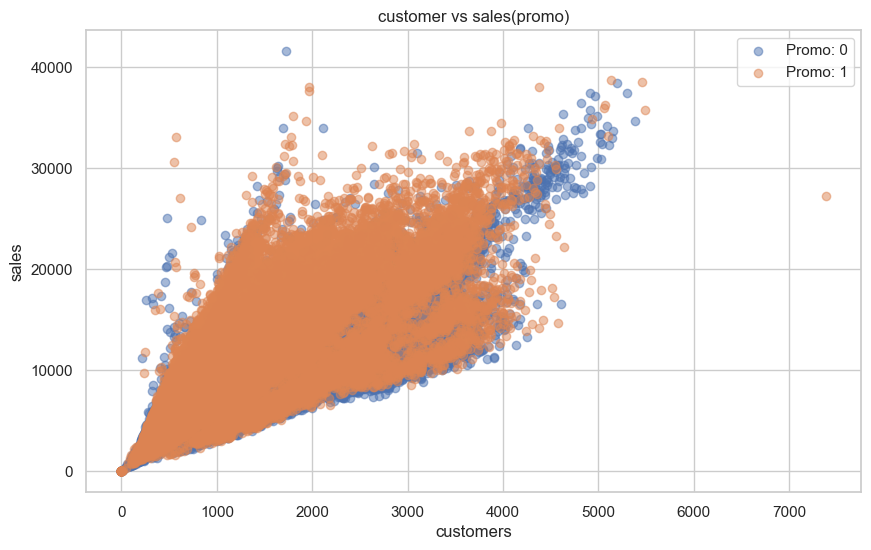

In [49]:
# 促销活动分析
promo_analysis = data.groupby('Promo').agg({
    'Sales': 'mean',
    'Customers': 'mean'
}).round(2)

print("促销活动对销售的影响：")
print(promo_analysis)

# 客流量与销售额的散点图（添加促销信息）
plt.figure(figsize=(10, 6))
for promo in [0, 1]:
    mask = data['Promo'] == promo
    plt.scatter(data[mask]['Customers'], 
               data[mask]['Sales'],
               alpha=0.5,
               label=f'Promo: {promo}')
plt.xlabel('customers')
plt.ylabel('sales')
plt.title('customer vs sales(promo)')
plt.legend()
plt.show()

In [50]:


# 创建月份特征
data['Month'] = data['Date'].dt.month

# 创建是否在促销间隔期内的特征
def is_in_promo_interval(row):
    if pd.isnull(row['PromoInterval']):
        return 0
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_str = months[row['Month']-1]
    return 1 if month_str in str(row['PromoInterval']) else 0

data['IsInPromoInterval'] = data.apply(is_in_promo_interval, axis=1)

# 2. 计算所有特征与销售额的相关性
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_columns].corr()['Sales'].sort_values(ascending=False)

print("所有特征与销售额的相关性：")
print(correlation_matrix)

# 3. 分析不同类型促销的效果
# 基础促销vs长期促销
promo_analysis = data.groupby(['Promo', 'Promo2']).agg({
    'Sales': ['mean', 'count'],
    'Customers': 'mean'
}).round(2)

print("\n不同促销类型的效果分析：")
print(promo_analysis)

# 4. 分析促销间隔的效果
interval_analysis = data.groupby(['IsInPromoInterval', 'Promo2']).agg({
    'Sales': ['mean', 'count'],
    'Customers': 'mean'
}).round(2)

print("\n促销间隔效果分析：")
print(interval_analysis)

所有特征与销售额的相关性：
Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
Promo2SinceWeek              0.095311
Month                        0.073600
SchoolHoliday                0.038617
CompetitionOpenSinceYear     0.016101
Store                        0.007710
Promo2SinceYear             -0.034713
CompetitionDistance         -0.036396
CompetitionOpenSinceMonth   -0.043489
IsInPromoInterval           -0.068069
Promo2                      -0.127596
DayOfWeek                   -0.178736
Open                              NaN
Name: Sales, dtype: float64

不同促销类型的效果分析：
                Sales         Customers
                 mean   count      mean
Promo Promo2                           
0     0       6327.97  234295    775.15
      1       5528.97  233201    618.20
1     0       8618.13  189012    928.57
      1       7836.09  187884    759.79

促销间隔效果分析：
                            Sales         Customers
                             me

特征相关性分析:


1. 客流量(Customers)与销售额相关性最高(0.824),说明客流是影响销售的最主要因素
2. 短期促销(Promo)与销售额呈正相关(0.368),但长期促销(Promo2)反而呈负相关(-0.128)
3. 星期几(DayOfWeek)呈负相关(-0.179),可能表示工作日销售反而更好
4. 竞争相关因素(CompetitionDistance等)相关性都很低,说明竞争对销售影响不大 （但这只是线性关系，相关性低并不代表特征对模型无用，因为，竞争相关因素可能与销售额存在非线性关系，将竞争相关因素重新纳入模型，模型的表现提升不大，安全地去掉。）


不同促销类型组合效果:


- 最好的组合是"仅短期促销"(Promo=1, Promo2=0):



- 最差的组合是"仅长期促销"(Promo=0, Promo2=1):

另外，在促销间隔期内(IsInPromoInterval=1)的销售额(6491.89)反而低于非促销期(7350.56)
这可能说明:促销时机选择可能不够优化；促销可能存在疲劳效应；需要重新设计促销策略的时间安排


Feature engineering

In [51]:
#  填充缺失值
data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
data['CompetitionOpenSinceYear'].fillna(0, inplace=True)
data['Promo2SinceWeek'].fillna(0, inplace=True)
data['Promo2SinceYear'].fillna(0, inplace=True)
data['PromoInterval'].fillna('None', inplace=True)

In [52]:
# 时间特征提取
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['WeekDay'] = data['Date'].dt.weekday  # 0-6, 0表示周一
data['IsWeekend'] = data['WeekDay'].isin([5, 6]).astype(int)  # 是否是周末

In [53]:
# 每个店铺的平均销售额和客流量
store_means = data.groupby('Store').agg({
    'Sales': 'mean',
    'Customers': 'mean'
}).reset_index()
store_means.columns = ['Store', 'StoreMeanSales', 'StoreMeanCustomers']
data = pd.merge(data, store_means, on='Store', how='left')

# 每个店铺类型的平均销售额
store_type_means = data.groupby('StoreType').agg({
    'Sales': 'mean'
}).reset_index()
store_type_means.columns = ['StoreType', 'StoreTypeMeanSales']
data = pd.merge(data, store_type_means, on='StoreType', how='left')


In [54]:
# 1. 基础促销特征
# Promo和Promo2的组合特征
data['PromoType'] = 0  # 默认无促销
data.loc[(data['Promo'] == 0) & (data['Promo2'] == 1), 'PromoType'] = 1  # 只有Promo2
data.loc[(data['Promo'] == 1) & (data['Promo2'] == 0), 'PromoType'] = 2  # 只有Promo
data.loc[(data['Promo'] == 1) & (data['Promo2'] == 1), 'PromoType'] = 3  # 两种促销都有

# 2. 促销间隔特征
# 判断是否在促销区间内
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data['MonthName'] = data['Date'].dt.strftime('%b')
data['IsInPromoInterval'] = data.apply(
    lambda x: 0 if x['PromoInterval'] == 'None' 
    else 1 if x['MonthName'] in x['PromoInterval'].split(',') 
    else 0, 
    axis=1
)

# 3. 促销效果特征
# 每个店铺在不同促销类型下的平均销售额和客流量
promo_store_stats = data.groupby(['Store', 'PromoType']).agg({
    'Sales': 'mean',
    'Customers': 'mean'
}).reset_index()
promo_store_stats.columns = ['Store', 'PromoType', 'StorePromoMeanSales', 'StorePromoMeanCustomers']
data = pd.merge(data, promo_store_stats, on=['Store', 'PromoType'], how='left')

# 4. 促销与时间的交互特征
data['WeekendPromo'] = (data['IsWeekend'] & (data['Promo'] == 1)).astype(int)
data['WeekdayPromo'] = (data['WeekDay'] & (data['Promo'] == 1)).astype(int)

# 5. 节假日特征
# 假期和促销的交互
# 将 '0' 转换为数字 0，其他非零值视为 1
data['StateHoliday'] = data['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 1, 'c': 1}).astype(int)
data['HolidayAndPromo'] = ((data['StateHoliday'] > 0) & (data['Promo'] == 1)).astype(int)
# 学校假期和促销的交互
data['SchoolHolidayAndPromo'] = (data['SchoolHoliday'] & (data['Promo'] == 1)).astype(int)

建模

XGBoost : 对非线性关系的建模能力强,内置了处理缺失值的机制，同时，对单调变换（如标准化）不敏感，能自动处理不同尺度的特征，更关注特征值的排序而不是绝对大小，所以也没做标准化。


TIME Features Importance:
   feature  importance
1    Month      7224.0
2  WeekDay      3720.0
0     Year      3706.0

STORE Features Importance:
              feature  importance
1  StoreMeanCustomers     14282.0
0      StoreMeanSales     12384.0
2  StoreTypeMeanSales      1534.0

PROMO Features Importance:
                   feature  importance
4  StorePromoMeanCustomers     13779.0
3      StorePromoMeanSales     10469.0
1        IsInPromoInterval      4717.0
0                PromoType      4049.0
2             WeekdayPromo      3796.0

HOLIDAY Features Importance:
                 feature  importance
0           StateHoliday       200.0
1        HolidayAndPromo       100.0
2  SchoolHolidayAndPromo       100.0
[0]	Validation-rmse:2847.89528
[1]	Validation-rmse:2619.94226
[2]	Validation-rmse:2419.74560
[3]	Validation-rmse:2243.14134
[4]	Validation-rmse:2089.07289
[5]	Validation-rmse:1954.26516
[6]	Validation-rmse:1837.41201
[7]	Validation-rmse:1736.02668
[8]	Validation-rmse:1649.3186

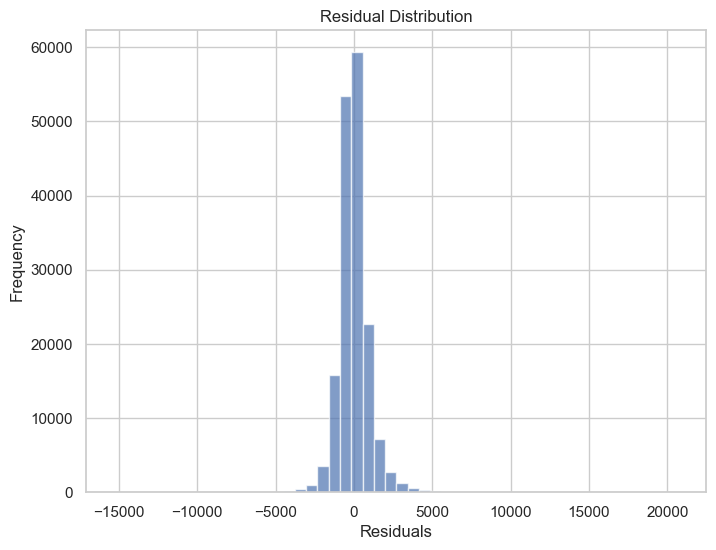

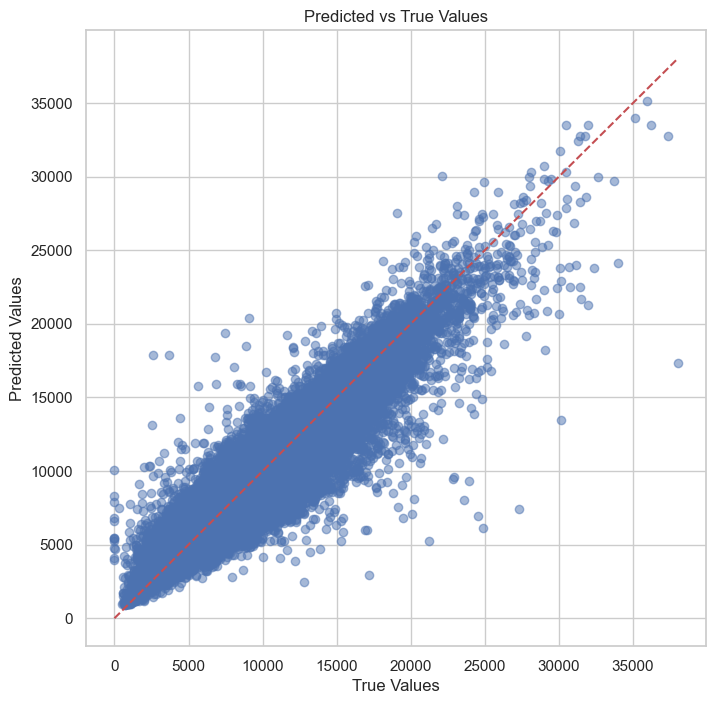


Overall TOP 15 Important Features:
                    feature  importance
1                     Month      8522.0
3            StoreMeanSales      7580.0
2                   WeekDay      6692.0
0                      Year      4915.0
4        StoreMeanCustomers      4877.0
9       StorePromoMeanSales      4044.0
10  StorePromoMeanCustomers      3135.0
6                 PromoType      1778.0
5        StoreTypeMeanSales      1683.0
13    SchoolHolidayAndPromo      1169.0
11             StateHoliday       554.0
7         IsInPromoInterval       499.0
8              WeekdayPromo       352.0
12          HolidayAndPromo        27.0


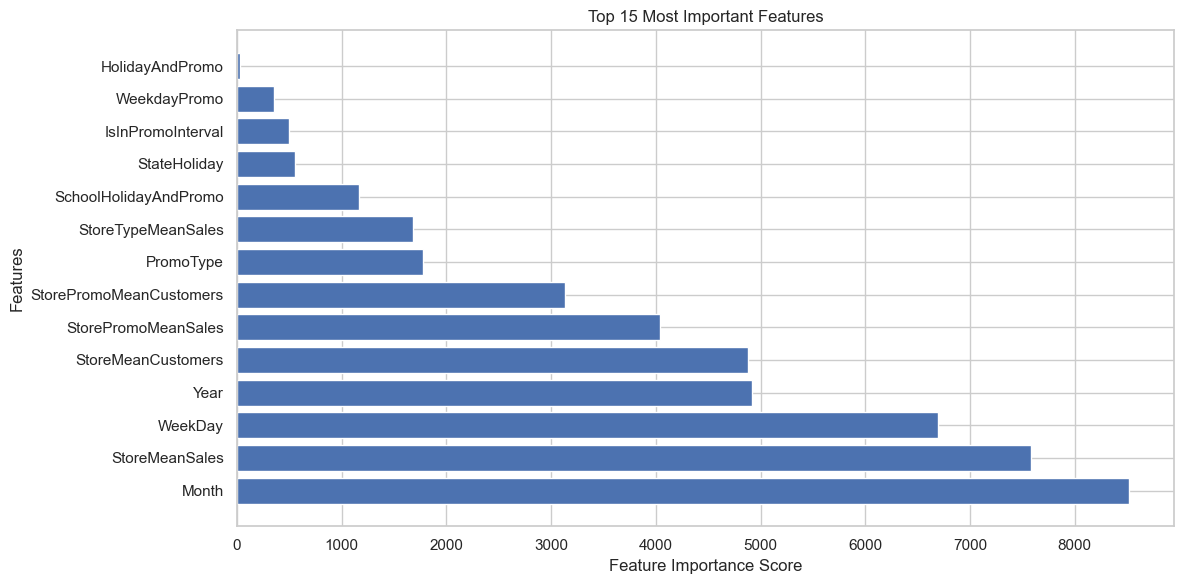

In [55]:


# 特征分组
time_features = ['Year', 'Month', 'WeekDay', 'IsWeekend']
store_features = ['StoreMeanSales', 'StoreMeanCustomers', 'StoreTypeMeanSales']
promo_features = ['PromoType', 'IsInPromoInterval', 'WeekendPromo', 'WeekdayPromo', 'StorePromoMeanSales', 'StorePromoMeanCustomers']
holiday_features = ['StateHoliday', 'HolidayAndPromo', 'SchoolHolidayAndPromo']

feature_groups = {
    'time': data[time_features],
    'store': data[store_features],
    'promo': data[promo_features],
    'holiday': data[holiday_features]
}

# 数据划分
X = pd.concat(feature_groups.values(), axis=1)
y = data['Sales']  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征组单独建模和分析
results = {}
for group_name, features in feature_groups.items():
    dtrain = xgb.DMatrix(features, label=y)
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 9,
        'eta': 0.1
    }
    model = xgb.train(params, dtrain, num_boost_round=100)
    
    # 获取特征重要性
    importance_dict = model.get_score(importance_type='weight')
    importance = pd.DataFrame([
        {'feature': feat, 'importance': imp} 
        for feat, imp in importance_dict.items()
    ]).sort_values('importance', ascending=False)
    
    results[group_name] = importance

# 打印每组特征重要性
for group_name, importance in results.items():
    print(f"\n{group_name.upper()} Features Importance:")
    print(importance)

# 整体建模和重要性分析
dtrain_all = xgb.DMatrix(X_train, label=y_train)
dval_all = xgb.DMatrix(X_val, label=y_val)

model_all = xgb.train(params, dtrain_all, num_boost_round=100, evals=[(dval_all, 'Validation')], early_stopping_rounds=10)

y_pred = model_all.predict(dval_all)
residuals = y_val - y_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()



# 获取总体特征重要性TOP 15
importance_dict_all = model_all.get_score(importance_type='weight')
overall_importance = pd.DataFrame([
    {'feature': feat, 'importance': imp} 
    for feat, imp in importance_dict_all.items()
]).sort_values('importance', ascending=False).head(15)

print("\nOverall TOP 15 Important Features:")
print(overall_importance)

# 可视化总体特征重要性
plt.figure(figsize=(12, 6))
plt.barh(overall_importance['feature'], overall_importance['importance'])
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


- Training Progress (RMSE Values):


The error consistently decreases throughout training, which is very positive<br>
The improvement rate slows down in later iterations, suggesting the model is converging<br>

- Residual Distribution:

The residuals follow a roughly normal distribution centered around 0<br>
The distribution is fairly symmetric, which is good<br>


- Predicted vs True Values:

The scatter plot shows a strong positive correlation between predicted and true values<br>
Points cluster well around the diagonal red line (perfect predictions)<br>
Some scatter at higher values indicates slightly less accurate predictions for extreme cases<br>
The spread is relatively consistent across the range, suggesting homoscedasticity<br>

In [56]:
# 设置不同的 max_depth 值
max_depth_values = [3, 5, 7, 9]
results_max_depth = {}

for depth in max_depth_values:
    params['max_depth'] = depth
    model = xgb.train(params, dtrain_all, num_boost_round=100, evals=[(dval_all, 'Validation')], early_stopping_rounds=10, verbose_eval=False)
    
    # 获取验证集上的 RMSE
    eval_result = model.eval(dval_all)
    rmse = float(eval_result.split(':')[1])
    results_max_depth[depth] = rmse
    print(f"max_depth={depth}, Validation RMSE={rmse:.4f}")

# 输出最优的 max_depth
best_depth = min(results_max_depth, key=results_max_depth.get)
print(f"\nBest max_depth: {best_depth}, RMSE: {results_max_depth[best_depth]:.4f}")


max_depth=3, Validation RMSE=1231.7104
max_depth=5, Validation RMSE=1144.8672
max_depth=7, Validation RMSE=1055.0220
max_depth=9, Validation RMSE=995.5734

Best max_depth: 9, RMSE: 995.5734



预测结果统计：
count    41088.000000
mean      6620.078125
std       2764.794678
min        713.000000
25%       4747.000000
50%       6171.000000
75%       7923.250000
max      31044.000000
Name: Sales, dtype: float64


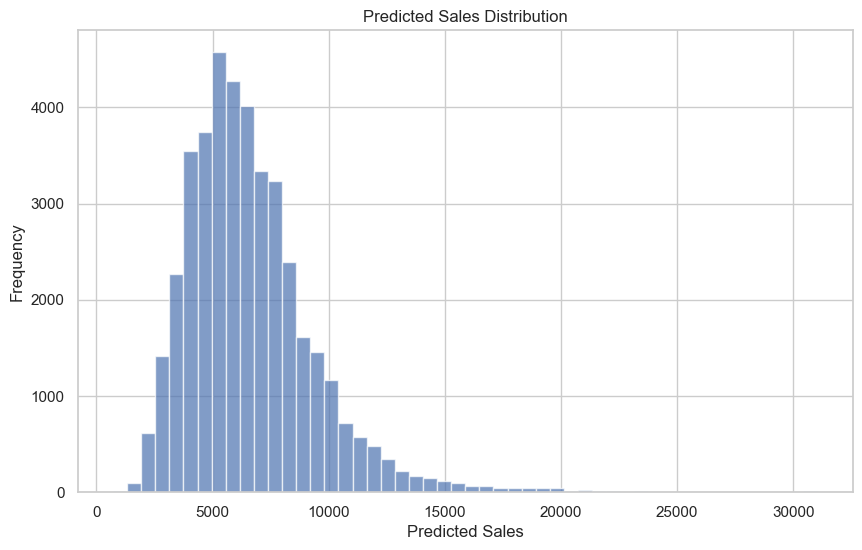

In [ ]:
# 将日期列转换为日期格式
test_df['Date'] = pd.to_datetime(test_df['Date'])

# 合并店铺信息
test_data = pd.merge(test_df, store_df, on='Store', how='left')

# 特征工程 - 与训练数据保持一致
# 填充缺失值
test_data['CompetitionDistance'].fillna(0, inplace=True)
test_data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
test_data['CompetitionOpenSinceYear'].fillna(0, inplace=True)
test_data['Promo2SinceWeek'].fillna(0, inplace=True)
test_data['Promo2SinceYear'].fillna(0, inplace=True)
test_data['PromoInterval'].fillna('None', inplace=True)

# 时间特征
test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month
test_data['WeekDay'] = test_data['Date'].dt.weekday
test_data['IsWeekend'] = test_data['WeekDay'].isin([5, 6]).astype(int)

# 店铺平均特征
store_means = data.groupby('Store').agg({
    'Sales': 'mean',
    'Customers': 'mean'
}).reset_index()
store_means.columns = ['Store', 'StoreMeanSales', 'StoreMeanCustomers']
test_data = pd.merge(test_data, store_means, on='Store', how='left')

# 店铺类型平均特征
store_type_means = data.groupby('StoreType').agg({
    'Sales': 'mean'
}).reset_index()
store_type_means.columns = ['StoreType', 'StoreTypeMeanSales']
test_data = pd.merge(test_data, store_type_means, on='StoreType', how='left')

# 促销特征
test_data['PromoType'] = 0
test_data.loc[(test_data['Promo'] == 0) & (test_data['Promo2'] == 1), 'PromoType'] = 1
test_data.loc[(test_data['Promo'] == 1) & (test_data['Promo2'] == 0), 'PromoType'] = 2
test_data.loc[(test_data['Promo'] == 1) & (test_data['Promo2'] == 1), 'PromoType'] = 3

# 促销间隔特征
test_data['MonthName'] = test_data['Date'].dt.strftime('%b')
test_data['IsInPromoInterval'] = test_data.apply(
    lambda x: 0 if x['PromoInterval'] == 'None' 
    else 1 if x['MonthName'] in x['PromoInterval'].split(',') 
    else 0, 
    axis=1
)

# 促销效果特征
promo_store_stats = data.groupby(['Store', 'PromoType']).agg({
    'Sales': 'mean',
    'Customers': 'mean'
}).reset_index()
promo_store_stats.columns = ['Store', 'PromoType', 'StorePromoMeanSales', 'StorePromoMeanCustomers']
test_data = pd.merge(test_data, promo_store_stats, on=['Store', 'PromoType'], how='left')

# 促销与时间的交互特征
test_data['WeekendPromo'] = (test_data['IsWeekend'] & (test_data['Promo'] == 1)).astype(int)
test_data['WeekdayPromo'] = (test_data['WeekDay'] & (test_data['Promo'] == 1)).astype(int)

# 节假日特征
test_data['StateHoliday'] = test_data['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 1, 'c': 1}).astype(int)
test_data['HolidayAndPromo'] = ((test_data['StateHoliday'] > 0) & (test_data['Promo'] == 1)).astype(int)
test_data['SchoolHolidayAndPromo'] = (test_data['SchoolHoliday'] & (test_data['Promo'] == 1)).astype(int)

# 准备测试特征
test_features = test_data[X.columns]

# 创建DMatrix
dtest = xgb.DMatrix(test_features)

test_predictions = model_all.predict(dtest)

# 创建提交文件
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'Sales': test_predictions.round()  # 四舍五入到整数
})

# 打印预测结果的基本统计信息
print("\n预测结果统计：")
print(submission['Sales'].describe())

# 可视化预测的销售分布
plt.figure(figsize=(10, 6))
plt.hist(submission['Sales'], bins=50, alpha=0.7)
plt.title('Predicted Sales Distribution')
plt.xlabel('Predicted Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()